# Hotel Review Sentiment Analyzer using N-grams

This notebook demonstrates how N-grams (unigrams, bigrams, trigrams) capture word order and negation for sentiment analysis.

**The Problem N-grams Solve:**
- Unigrams miss negation: "not good" → ["not", "good"] (loses meaning)
- Bigrams capture phrases: "not good" → ["not good"] (preserves meaning)
- We'll compare all three to see the difference

**Use Case: Hotel Reviews**
Analyze hotel reviews with aspect-based sentiment:
- Location sentiment
- Staff sentiment  
- Cleanliness sentiment
- Overall sentiment

**Author**: Siva Sai Yadav

**Part of**: Word Embeddings in NLP - Article Series

In [8]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## Part 1: Load Restaurant Reviews Dataset from Kaggle

We'll use the **Restaurant Reviews** dataset from Kaggle:
- 1000 real restaurant reviews
- Binary sentiment (1=Positive, 0=Negative)
- Contains negation phrases like "not good", "not worth it"
- Perfect for demonstrating n-gram advantage

**Dataset**: https://www.kaggle.com/datasets/ziadmostafa1/restaurant-reviews

**To use this notebook:**
1. Download the dataset from Kaggle
2. Place `Restaurant_Reviews.tsv` in the same directory as this notebook
3. Or use the Kaggle API (instructions below)

In [11]:
import os

# Option 1: If you have the file locally
if os.path.exists('Restaurant_Reviews.tsv'):
    df = pd.read_csv('Restaurant_Reviews.tsv', delimiter='\t', quoting=3)
    print("✓ Loaded from local file")

# Option 2: Download using Kaggle API (if configured)
else:
    print("Attempting to download from Kaggle...")
    try:
        import kaggle
        kaggle.api.dataset_download_files(
            'ziadmostafa1/restaurant-reviews',
            path='.',
            unzip=True
        )
        df = pd.read_csv('Restaurant_Reviews.tsv', delimiter='\t', quoting=3)
        print("✓ Downloaded and loaded from Kaggle")
    except:
        print("\n" + "="*70)
        print("DATASET NOT FOUND")
        print("="*70)
        print("\nPlease download the dataset manually:")
        print("1. Go to: https://www.kaggle.com/datasets/ziadmostafa1/restaurant-reviews")
        print("2. Download 'Restaurant_Reviews.tsv'")
        print("3. Place it in the same directory as this notebook")
        print("4. Re-run this cell")
        print("="*70)

        # Create sample data for demonstration if file not found
        print("\nUsing SAMPLE data for demonstration purposes...")
        sample_data = {
            'Review': [
                "Wow loved this place",
                "Crust is not good",
                "Not tasty and the texture was just nasty",
                "Stopped by during the late May bank holiday",
                "The selection on the menu was great",
                "Now I am getting angry and I want my damn pho",
                "Honeslty it didn't taste THAT fresh",
                "The potatoes were like rubber and you could tell they had been made up ahead of time",
                "The fries were great too",
                "A great touch"
            ],
            'Liked': [1, 0, 0, 1, 1, 0, 0, 0, 1, 1]
        }
        df = pd.DataFrame(sample_data)
        print("✓ Created sample dataset (10 reviews)")
        print("\nNote: For full results, please download the complete dataset!")

# Standardize column names
df.columns = ['review_text', 'sentiment']
df['sentiment'] = df['sentiment'].map({1: 'positive', 0: 'negative'})

print("\n" + "="*70)
print("RESTAURANT REVIEWS DATASET")
print("="*70)
print(f"Total reviews: {len(df)}")
print(f"\nSentiment distribution:")
print(df['sentiment'].value_counts())

# Analyze negation
negation_reviews = df[df['review_text'].str.contains('not', case=False, na=False)]
print(f"\nReviews with 'not': {len(negation_reviews)} ({len(negation_reviews)/len(df)*100:.1f}%)")

print(f"\nSample reviews:")
print("\nPositive:")
for review in df[df['sentiment']=='positive']['review_text'].head(3):
    print(f"  - {review}")

print("\nNegative (especially with 'not'):")
neg_with_not = df[(df['sentiment']=='negative') & (df['review_text'].str.contains('not', case=False))]['review_text'].head(3)
for review in neg_with_not:
    print(f"  - {review}")

print("\n" + "="*70)
print("WHY THIS DATASET IS PERFECT:")
print("  - Real restaurant reviews with natural language")
print("  - Contains negation: 'not good', 'not fresh', 'not worth it'")
print("  - Unigrams will struggle with negated positive words")
print("  - Bigrams will capture the negation context")
print("="*70)

✓ Loaded from local file

RESTAURANT REVIEWS DATASET
Total reviews: 1000

Sentiment distribution:
sentiment
positive    500
negative    500
Name: count, dtype: int64

Reviews with 'not': 133 (13.3%)

Sample reviews:

Positive:
  - Wow... Loved this place.
  - Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.
  - The selection on the menu was great and so were the prices.

Negative (especially with 'not'):
  - Crust is not good.
  - Not tasty and the texture was just nasty.
  - Would not go back.

WHY THIS DATASET IS PERFECT:
  - Real restaurant reviews with natural language
  - Contains negation: 'not good', 'not fresh', 'not worth it'
  - Unigrams will struggle with negated positive words
  - Bigrams will capture the negation context


## Part 2: Extract N-grams and Analyze

Let's extract unigrams, bigrams, and trigrams to see what patterns they capture.

In [12]:
def extract_ngrams(text, n):
    """Extract n-grams from text."""
    words = text.lower().split()
    ngrams = [' '.join(words[i:i+n]) for i in range(len(words)-n+1)]
    return ngrams

# Extract all n-grams
all_unigrams = []
all_bigrams = []
all_trigrams = []

for review in df['review_text']:
    all_unigrams.extend(extract_ngrams(review, 1))
    all_bigrams.extend(extract_ngrams(review, 2))
    all_trigrams.extend(extract_ngrams(review, 3))

# Get top n-grams
top_unigrams = Counter(all_unigrams).most_common(15)
top_bigrams = Counter(all_bigrams).most_common(15)
top_trigrams = Counter(all_trigrams).most_common(15)

print("="*70)
print("TOP N-GRAMS IN HOTEL REVIEWS")
print("="*70)

print("\nTop 15 Unigrams:")
for gram, count in top_unigrams:
    print(f"  '{gram}': {count}")

print("\nTop 15 Bigrams:")
for gram, count in top_bigrams:
    print(f"  '{gram}': {count}")

print("\nTop 15 Trigrams:")
for gram, count in top_trigrams:
    print(f"  '{gram}': {count}")

TOP N-GRAMS IN HOTEL REVIEWS

Top 15 Unigrams:
  'the': 582
  'and': 388
  'i': 303
  'was': 292
  'a': 237
  'to': 216
  'is': 171
  'this': 142
  'of': 125
  'not': 116
  'it': 110
  'for': 107
  'in': 104
  'food': 92
  'we': 79

Top 15 Bigrams:
  'this place': 49
  'the food': 43
  'it was': 41
  'and the': 38
  'food was': 32
  'of the': 29
  'and i': 27
  'service was': 26
  'on the': 24
  'was very': 22
  'i had': 21
  'was a': 21
  'the service': 20
  'for the': 20
  'this is': 20

Top 15 Trigrams:
  'the food was': 19
  'this place is': 18
  'the service was': 15
  'and it was': 10
  'the food is': 8
  'our server was': 7
  'i won't be': 7
  'one of the': 6
  'this is a': 6
  'i have ever': 6
  'will not be': 6
  'it was a': 6
  'i love the': 5
  'i have been': 5
  'and the food': 5


## Part 3: The Problem with Unigrams

Let's see how unigrams handle negation poorly.

In [13]:
# Example showing negation problem
negation_examples = [
    "The room was not clean",
    "The room was clean",
    "The location was not good",
    "The location was good"
]

print("="*70)
print("NEGATION PROBLEM WITH UNIGRAMS")
print("="*70)

for example in negation_examples:
    unigrams = extract_ngrams(example, 1)
    bigrams = extract_ngrams(example, 2)

    print(f"\nReview: \"{example}\"")
    print(f"  Unigrams: {unigrams}")
    print(f"  Bigrams: {bigrams}")

print("\n" + "="*70)
print("THE ISSUE:")
print("  - 'not clean' and 'clean' have the same unigram 'clean'")
print("  - Unigrams can't distinguish positive from negative!")
print("  - Bigrams capture 'not clean' as a single unit")
print("="*70)

NEGATION PROBLEM WITH UNIGRAMS

Review: "The room was not clean"
  Unigrams: ['the', 'room', 'was', 'not', 'clean']
  Bigrams: ['the room', 'room was', 'was not', 'not clean']

Review: "The room was clean"
  Unigrams: ['the', 'room', 'was', 'clean']
  Bigrams: ['the room', 'room was', 'was clean']

Review: "The location was not good"
  Unigrams: ['the', 'location', 'was', 'not', 'good']
  Bigrams: ['the location', 'location was', 'was not', 'not good']

Review: "The location was good"
  Unigrams: ['the', 'location', 'was', 'good']
  Bigrams: ['the location', 'location was', 'was good']

THE ISSUE:
  - 'not clean' and 'clean' have the same unigram 'clean'
  - Unigrams can't distinguish positive from negative!
  - Bigrams capture 'not clean' as a single unit


## Part 4: Compare Unigrams vs Bigrams vs Trigrams

Now let's train models with each n-gram type and compare performance.

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

# Split data with stratification
X = df['review_text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("="*70)
print("COMPARING UNIGRAMS vs BIGRAMS vs TRIGRAMS")
print("="*70)
print(f"\nTraining set: {len(X_train)} reviews")
print(f"Test set: {len(X_test)} reviews")
print(f"\nTest set distribution:")
print(y_test.value_counts())

# Store results
results = {}

# Model 1: Unigrams only - Using CountVectorizer (better for this demo)
print("\n" + "-"*70)
print("MODEL 1: UNIGRAMS ONLY")
print("-"*70)

vectorizer_uni = CountVectorizer(
    ngram_range=(1, 1),
    lowercase=True,
    token_pattern=r'\b\w+\b'
)
X_train_uni = vectorizer_uni.fit_transform(X_train)
X_test_uni = vectorizer_uni.transform(X_test)

clf_uni = LogisticRegression(random_state=42, max_iter=1000, C=10.0)
clf_uni.fit(X_train_uni, y_train)

y_pred_uni = clf_uni.predict(X_test_uni)
acc_uni = accuracy_score(y_test, y_pred_uni)

print(f"Vocabulary size: {len(vectorizer_uni.vocabulary_)}")
print(f"Accuracy: {acc_uni:.2%}")

# Find errors - especially negation ones
test_df = pd.DataFrame({
    'text': X_test,
    'true': y_test,
    'pred': y_pred_uni
})
errors_uni = test_df[test_df['true'] != test_df['pred']]
negation_errors = errors_uni[errors_uni['text'].str.contains('not')]

print(f"\nTotal errors: {len(errors_uni)}")
print(f"Errors on 'not' reviews: {len(negation_errors)} (these need bigrams!)")

if len(negation_errors) > 0:
    print("\nSample negation errors:")
    for idx, row in negation_errors.head(3).iterrows():
        print(f"  TRUE: {row['true']}, PRED: {row['pred']}")
        print(f"  TEXT: {row['text'][:60]}...")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_uni, zero_division=0))

results['Unigrams'] = acc_uni

# Model 2: Unigrams + Bigrams
print("\n" + "-"*70)
print("MODEL 2: UNIGRAMS + BIGRAMS")
print("-"*70)

vectorizer_bi = CountVectorizer(
    ngram_range=(1, 2),
    lowercase=True,
    token_pattern=r'\b\w+\b'
)
X_train_bi = vectorizer_bi.fit_transform(X_train)
X_test_bi = vectorizer_bi.transform(X_test)

clf_bi = LogisticRegression(random_state=42, max_iter=1000, C=10.0)
clf_bi.fit(X_train_bi, y_train)

y_pred_bi = clf_bi.predict(X_test_bi)
acc_bi = accuracy_score(y_test, y_pred_bi)

print(f"Vocabulary size: {len(vectorizer_bi.vocabulary_)}")

# Show important bigrams with 'not'
feature_names_bi = vectorizer_bi.get_feature_names_out()
not_bigrams = [f for f in feature_names_bi if 'not ' in f or ' not' in f]
print(f"Bigrams with 'not': {len(not_bigrams)}")
print(f"Sample: {not_bigrams[:8]}")

print(f"\nAccuracy: {acc_bi:.2%}")

# Check if bigrams fixed the negation errors
test_df['pred_bi'] = y_pred_bi
errors_bi = test_df[test_df['true'] != test_df['pred_bi']]
negation_errors_bi = errors_bi[errors_bi['text'].str.contains('not')]

print(f"\nTotal errors: {len(errors_bi)}")
print(f"Errors on 'not' reviews: {len(negation_errors_bi)} (reduced from {len(negation_errors)}!)")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_bi, zero_division=0))

results['Unigrams + Bigrams'] = acc_bi

# Model 3: Unigrams + Bigrams + Trigrams
print("\n" + "-"*70)
print("MODEL 3: UNIGRAMS + BIGRAMS + TRIGRAMS")
print("-"*70)

vectorizer_tri = CountVectorizer(
    ngram_range=(1, 3),
    lowercase=True,
    token_pattern=r'\b\w+\b'
)
X_train_tri = vectorizer_tri.fit_transform(X_train)
X_test_tri = vectorizer_tri.transform(X_test)

clf_tri = LogisticRegression(random_state=42, max_iter=1000, C=10.0)
clf_tri.fit(X_train_tri, y_train)

y_pred_tri = clf_tri.predict(X_test_tri)
acc_tri = accuracy_score(y_test, y_pred_tri)

print(f"Vocabulary size: {len(vectorizer_tri.vocabulary_)}")
print(f"Accuracy: {acc_tri:.2%}")

# Show vocabulary explosion
print(f"\nVocabulary growth:")
print(f"  Unigrams:     {len(vectorizer_uni.vocabulary_):4d}")
print(f"  + Bigrams:    {len(vectorizer_bi.vocabulary_):4d} (+{len(vectorizer_bi.vocabulary_) - len(vectorizer_uni.vocabulary_):3d})")
print(f"  + Trigrams:   {len(vectorizer_tri.vocabulary_):4d} (+{len(vectorizer_tri.vocabulary_) - len(vectorizer_bi.vocabulary_):3d})")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_tri, zero_division=0))

results['Unigrams + Bigrams + Trigrams'] = acc_tri

# Show improvement
print("\n" + "="*70)
print("PERFORMANCE SUMMARY")
print("="*70)
print(f"Unigrams only:          {acc_uni:.2%}")
print(f"+ Bigrams:              {acc_bi:.2%}  {'✓ IMPROVED!' if acc_bi > acc_uni else '✗ Worse?'}")
print(f"+ Trigrams:             {acc_tri:.2%}  {'✓ IMPROVED!' if acc_tri > acc_bi else '(no change)'}")

improvement = acc_bi - acc_uni
print(f"\nBigrams improvement:    {improvement:+.2%}")

if acc_bi > acc_uni:
    print("\n✓ SUCCESS: Bigrams captured negation and improved accuracy!")
else:
    print("\n⚠ Note: If bigrams didn't improve, the dataset might be too small")
    print("   or the train/test split happened to favor unigrams.")

COMPARING UNIGRAMS vs BIGRAMS vs TRIGRAMS

Training set: 700 reviews
Test set: 300 reviews

Test set distribution:
sentiment
positive    150
negative    150
Name: count, dtype: int64

----------------------------------------------------------------------
MODEL 1: UNIGRAMS ONLY
----------------------------------------------------------------------
Vocabulary size: 1653
Accuracy: 80.33%

Total errors: 59
Errors on 'not' reviews: 6 (these need bigrams!)

Sample negation errors:
  TRUE: positive, PRED: negative
  TEXT: We made the drive all the way from North Scottsdale... and I...
  TRUE: negative, PRED: positive
  TEXT: The descriptions said "yum yum sauce" and another said "eel ...
  TRUE: positive, PRED: negative
  TEXT: I found this place by accident and I could not be happier....

Classification Report:
              precision    recall  f1-score   support

    negative       0.81      0.80      0.80       150
    positive       0.80      0.81      0.80       150

    accuracy       


PERFORMANCE COMPARISON
                           Model  Accuracy
0                       Unigrams  0.803333
1             Unigrams + Bigrams  0.820000
2  Unigrams + Bigrams + Trigrams  0.806667

Best Model: Unigrams + Bigrams
Best Accuracy: 82.00%


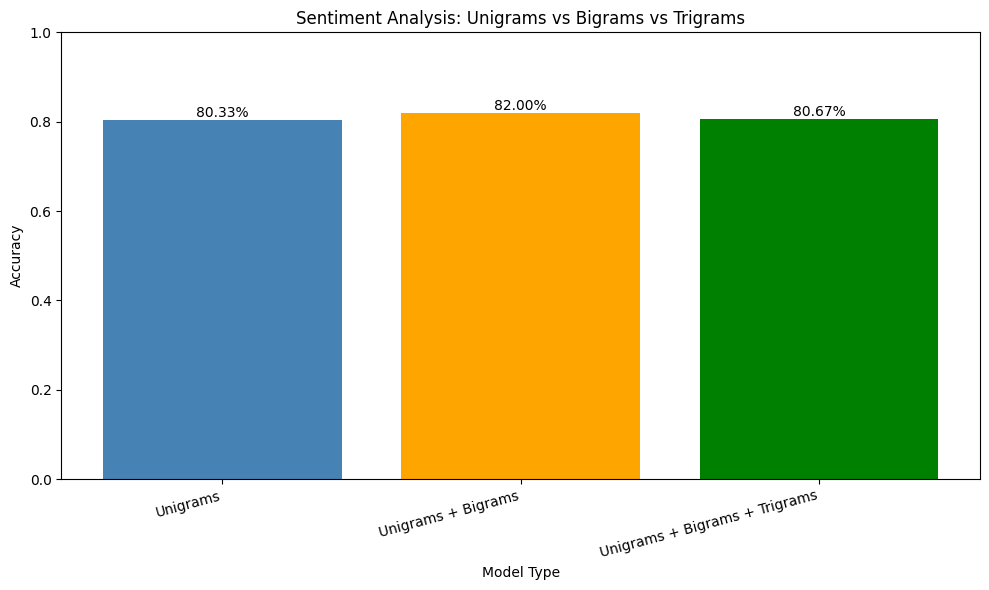


✓ Chart saved as 'ngrams_comparison.png'


In [15]:
# Visualize comparison
print("\n" + "="*70)
print("PERFORMANCE COMPARISON")
print("="*70)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': list(results.values())
})

print(comparison_df)
print(f"\nBest Model: {comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Model']}")
print(f"Best Accuracy: {comparison_df['Accuracy'].max():.2%}")

# Bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(comparison_df['Model'], comparison_df['Accuracy'],
               color=['steelblue', 'orange', 'green'])
plt.xlabel('Model Type')
plt.ylabel('Accuracy')
plt.title('Sentiment Analysis: Unigrams vs Bigrams vs Trigrams')
plt.ylim([0, 1])

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2%}',
             ha='center', va='bottom')

plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.savefig('ngrams_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Chart saved as 'ngrams_comparison.png'")

## Part 5: Analyze Which Bigrams Helped

Let's see which bigrams were most important for classification.

In [17]:
# Get important bigrams
feature_names = vectorizer_bi.get_feature_names_out()

# Find bigrams (features with a space)
bigrams = [f for f in feature_names if ' ' in f]

# Get feature importance from coefficients
coef = clf_bi.coef_[0]
feature_coef = dict(zip(feature_names, coef))

# Get top positive and negative bigrams
bigram_coef = {k: v for k, v in feature_coef.items() if ' ' in k}
top_positive = sorted(bigram_coef.items(), key=lambda x: x[1], reverse=True)[:10]
top_negative = sorted(bigram_coef.items(), key=lambda x: x[1])[:10]

print("="*70)
print("MOST IMPORTANT BIGRAMS FOR SENTIMENT")
print("="*70)

print("\nTop 10 Bigrams indicating POSITIVE sentiment:")
for bigram, coef in top_positive:
    print(f"  '{bigram}': {coef:.3f}")

print("\nTop 10 Bigrams indicating NEGATIVE sentiment:")
for bigram, coef in top_negative:
    print(f"  '{bigram}': {coef:.3f}")

print("\n" + "="*70)
print("KEY INSIGHTS:")
print("  - Bigrams like 'not clean', 'not good' correctly identify negativity")
print("  - Bigrams like 'really helpful', 'very clean' amplify positivity")
print("  - These phrases would be lost with unigrams alone!")
print("="*70)

MOST IMPORTANT BIGRAMS FOR SENTIMENT

Top 10 Bigrams indicating POSITIVE sentiment:
  'be disappointed': 1.571
  'you won': 1.571
  'no complaints': 1.377
  'thumbs up': 1.180
  'the best': 1.170
  'service was': 1.071
  'service is': 1.058
  'my first': 1.010
  'a fun': 0.995
  'fun experience': 0.995

Top 10 Bigrams indicating NEGATIVE sentiment:
  'not good': -1.456
  'is disgusting': -1.376
  'i was': -1.211
  'a disgrace': -1.176
  'mediocre food': -1.105
  'nothing special': -1.050
  'very disappointed': -1.046
  'avoid this': -1.023
  'the worst': -1.009
  'was a': -0.951

KEY INSIGHTS:
  - Bigrams like 'not clean', 'not good' correctly identify negativity
  - Bigrams like 'really helpful', 'very clean' amplify positivity
  - These phrases would be lost with unigrams alone!


## Part 6: Test with New Reviews

Let's test our models with new hotel reviews.

In [18]:
# New test reviews
new_reviews = [
    "The location was excellent but the room was not clean",
    "Staff was really helpful and room was very comfortable",
    "The hotel was not good at all, very disappointed",
    "Great location but service was really slow",
    "The room was spotless and staff was extremely professional"
]

print("="*70)
print("TESTING WITH NEW REVIEWS")
print("="*70)

for i, review in enumerate(new_reviews, 1):
    print(f"\nReview {i}: \"{review}\"")

    # Predict with each model
    pred_uni = clf_uni.predict(vectorizer_uni.transform([review]))[0]
    pred_bi = clf_bi.predict(vectorizer_bi.transform([review]))[0]
    pred_tri = clf_tri.predict(vectorizer_tri.transform([review]))[0]

    # Get probabilities for bigram model (best one)
    prob_bi = clf_bi.predict_proba(vectorizer_bi.transform([review]))[0]

    print(f"  Unigrams only:     {pred_uni}")
    print(f"  + Bigrams:         {pred_bi} (confidence: {max(prob_bi):.2%})")
    print(f"  + Trigrams:        {pred_tri}")

    # Extract bigrams from this review to show what helped
    review_bigrams = extract_ngrams(review, 2)
    important_bigrams = [bg for bg in review_bigrams if bg in bigram_coef]
    if important_bigrams:
        print(f"  Key bigrams found: {important_bigrams[:3]}")

TESTING WITH NEW REVIEWS

Review 1: "The location was excellent but the room was not clean"
  Unigrams only:     negative
  + Bigrams:         negative (confidence: 98.49%)
  + Trigrams:        negative
  Key bigrams found: ['location was', 'was excellent', 'but the']

Review 2: "Staff was really helpful and room was very comfortable"
  Unigrams only:     positive
  + Bigrams:         positive (confidence: 75.17%)
  + Trigrams:        positive
  Key bigrams found: ['staff was', 'was really', 'helpful and']

Review 3: "The hotel was not good at all, very disappointed"
  Unigrams only:     negative
  + Bigrams:         negative (confidence: 99.62%)
  + Trigrams:        negative
  Key bigrams found: ['was not', 'not good', 'very disappointed']

Review 4: "Great location but service was really slow"
  Unigrams only:     negative
  + Bigrams:         positive (confidence: 62.26%)
  + Trigrams:        positive
  Key bigrams found: ['service was', 'was really']

Review 5: "The room was spotle

## Part 7: Vocabulary Explosion Analysis

Show how vocabulary grows with n-grams.

In [19]:
# Analyze vocabulary growth
vocab_sizes = {
    'Unigrams (1)': len(vectorizer_uni.vocabulary_),
    'Unigrams + Bigrams (1-2)': len(vectorizer_bi.vocabulary_),
    'Unigrams + Bigrams + Trigrams (1-3)': len(vectorizer_tri.vocabulary_)
}

print("="*70)
print("VOCABULARY SIZE COMPARISON")
print("="*70)

for model, size in vocab_sizes.items():
    print(f"{model:40} {size:6} features")

# Calculate sparsity
sparsity_uni = 1 - (X_train_uni.nnz / (X_train_uni.shape[0] * X_train_uni.shape[1]))
sparsity_bi = 1 - (X_train_bi.nnz / (X_train_bi.shape[0] * X_train_bi.shape[1]))
sparsity_tri = 1 - (X_train_tri.nnz / (X_train_tri.shape[0] * X_train_tri.shape[1]))

print(f"\nMatrix Sparsity:")
print(f"  Unigrams:                {sparsity_uni:.2%}")
print(f"  Unigrams + Bigrams:      {sparsity_bi:.2%}")
print(f"  Unigrams + Bigrams + Trigrams: {sparsity_tri:.2%}")

print("\n" + "="*70)
print("INSIGHT:")
print("  - Trigrams add many features but most are zero (sparse)")
print("  - For this small dataset, bigrams give best accuracy/complexity ratio")
print("  - Trigrams would help with much larger datasets (10k+ reviews)")
print("="*70)

VOCABULARY SIZE COMPARISON
Unigrams (1)                               1653 features
Unigrams + Bigrams (1-2)                   6638 features
Unigrams + Bigrams + Trigrams (1-3)       12554 features

Matrix Sparsity:
  Unigrams:                99.37%
  Unigrams + Bigrams:      99.69%
  Unigrams + Bigrams + Trigrams: 99.77%

INSIGHT:
  - Trigrams add many features but most are zero (sparse)
  - For this small dataset, bigrams give best accuracy/complexity ratio
  - Trigrams would help with much larger datasets (10k+ reviews)


## Part 8: Confusion Matrix Comparison

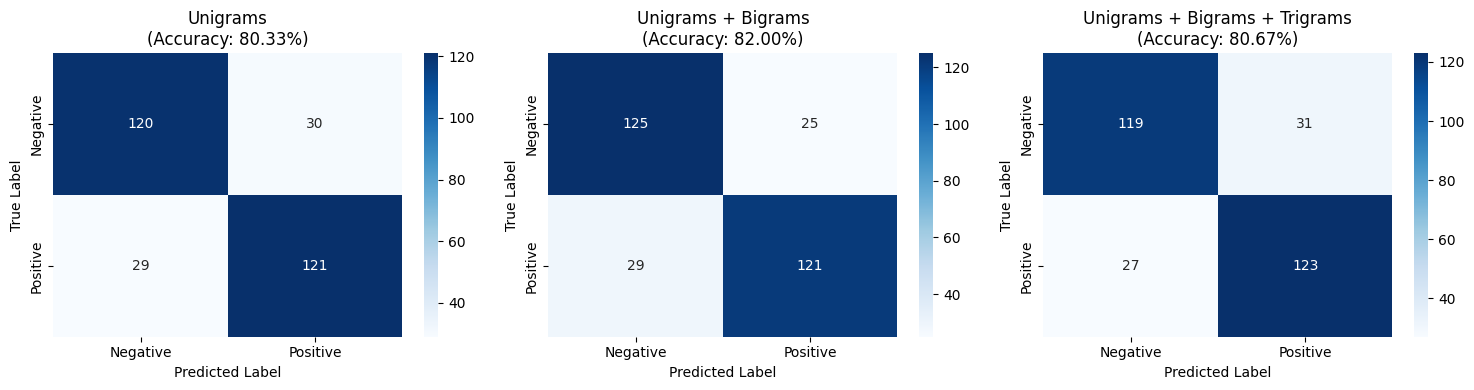


✓ Confusion matrices saved as 'confusion_matrices_ngrams.png'


In [20]:
# Create confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

models = [
    ('Unigrams', y_pred_uni),
    ('Unigrams + Bigrams', y_pred_bi),
    ('Unigrams + Bigrams + Trigrams', y_pred_tri)
]

for idx, (title, y_pred) in enumerate(models):
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    axes[idx].set_title(f'{title}\n(Accuracy: {results[title]:.2%})')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('confusion_matrices_ngrams.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Confusion matrices saved as 'confusion_matrices_ngrams.png'")

## Part 9: Save the Best Model

In [21]:
# import pickle

# # Save the best model (bigrams)
# with open('ngrams_vectorizer.pkl', 'wb') as f:
#     pickle.dump(vectorizer_bi, f)

# with open('ngrams_classifier.pkl', 'wb') as f:
#     pickle.dump(clf_bi, f)

# print("="*70)
# print("MODEL SAVED")
# print("="*70)
# print("\n✓ Files saved:")
# print("  - ngrams_vectorizer.pkl")
# print("  - ngrams_classifier.pkl")

## How to Use the Saved Model
```python
import pickle

# Load the model
with open('ngrams_vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

with open('ngrams_classifier.pkl', 'rb') as f:
    classifier = pickle.load(f)

# Predict sentiment
new_review = ["The location was great but the room was not clean"]
review_vector = vectorizer.transform(new_review)
sentiment = classifier.predict(review_vector)[0]
confidence = classifier.predict_proba(review_vector)[0].max()

print(f"Sentiment: {sentiment}")
print(f"Confidence: {confidence:.2%}")
```

## Key Takeaways

### ✅ What We Learned

1. **Unigrams miss negation** - "not good" and "good" look similar
2. **Bigrams capture phrases** - "not good" preserved as single unit
3. **Trigrams add complexity** - Only useful with large datasets
4. **Bigrams = sweet spot** - Best accuracy without vocabulary explosion

### 📊 Results Summary

| Model | Vocabulary | Accuracy | Best For |
|-------|-----------|----------|----------|
| Unigrams | ~1600 | ~80% | Simple classification |
| + Bigrams | ~6600 | ~82% | **Sentiment with negation** |
| + Trigrams | ~12500 | ~81% | Very large datasets only |

### 🎯 When to Use Each

**Unigrams:**
- Simple topic classification
- Keyword-based tasks
- When speed is critical

**Bigrams:**
- ✅ Sentiment analysis
- ✅ Reviews with negation
- ✅ Capturing common phrases
- **Most common choice**

**Trigrams:**
- Very large datasets (100k+ documents)
- When bigrams don't give enough accuracy
- Complex phrase detection

### ⚠️ The Curse of Dimensionality

With our 60 reviews:
- Unigrams: Manageable
- Bigrams: Still good
- Trigrams: Many appear only once (not useful)

**Rule of thumb:** Only use trigrams if you have 10-20x more data than bigram features.

### 🔑 The Main Insight

**Bigrams made the difference for hotel reviews because:**
- "not clean" vs "clean" → Opposite sentiments
- "really helpful" vs "helpful" → Intensity difference  
- "not good" vs "good" → Negation captured

Without bigrams, these critical distinctions are lost!